# Practical 3 > Part 1

This is the first task of Practical 3. You will build a neural network to classify the handwritten digits from the MNIST dataset (http://yann.lecun.com/exdb/mnist/). You will build the classifier from scartch. We will mark your code based on the accuracy of your model. You should get **at least 97%** accuracy on this dataset. Don't forget to save and check in your model. 

## Report
First of all we are importing all needed libraries and checking the version of TensorFlow, Keras and Matplotlib. The highest version of TensorFlow available in Anaconda-Navigator was 2.2 but we want to use 2.4. This version had to be installed seperately via command line. Next, we visualized the data in order to get a better understanding for the problem. 

The data is prepared for training by converting the pixel values of the images to the interval [0,1] and one hot encoding the y labels. And then we obtained 5,000 validation data points out of the 50,000 training data points.

We tried out different CNN architectures. The best performing one we found contains a convoluational layer at first with 64 filters followed by a (2,2) max pooling layer. Then another convolutional layer with 32 filters follows including another max pooling layer (2,2). We flatten the output and use an output layer with 10 neurons and softmax activation. One output neuron for each classes. We use ReLU activation for each convolutional layer and HE normal initialization. Since deep neural networks face the difficulty that the variance of layer outputs reduces when moving upstream. Kumar proved it is best to have variances around 1 in each layer in order to avoid vanishing and exploding gradient problems.

Early stopping with a patience of 5 is used during the training process in order to stop when no further improvement is achieved and a ModelCheckpoint is used to save the Model with the highest validation accuracy. We also tried cross validation with 5 and 10 folds we received good validation accuracies (>97%) in the final epoch of all k training processes. Instead of building an enseble model out of these k models or taking the one with the highest validation accuracy we decided, we decided to take the same network architecture and train it on the full training dataset.
We usually achieve a validation and testing accuracy of over 98%.

Contributions: Over Christmas, Giuseppe and Maida focused on practical number two and Jan focused on this assignment.

## 1. Importing needed libraries

In [151]:
import numpy as np
from numpy.random import RandomState

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
%load_ext tensorboard
from tensorflow import keras

# cnn model with batch normalization for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import BatchNormalization

from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [152]:
#Put program into verbose or non verbose mode.
verbose = 1

In [153]:
#Check if we are using proper versions of Keras and TensorFlow.
if verbose:
    print('TensorFlow Version: %s' % tf.__version__)
    print('Keras Version: %s' % keras.__version__)
    print('Matplotlib Version: %s' % matplotlib.__version__)

TensorFlow Version: 2.4.0
Keras Version: 2.4.0
Matplotlib Version: 3.3.3


## 2. Visualize the dataset
First of all the training dataset is visualized.
It contains 28 x 28 images with with only one color channel depicting numbers from 0 to 9.

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Prediction for Image-0 => 3
Prediction for Image-1 => 3
Prediction for Image-2 => 9
Prediction for Image-3 => 3
Prediction for Image-4 => 1
Prediction for Image-5 => 5
Prediction for Image-6 => 8
Prediction for Image-7 => 6
Prediction for Image-8 => 9


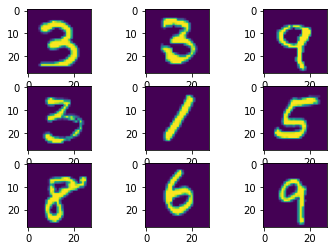

X_train.dtype: uint8
X_test.dtype: uint8


In [154]:
# Load the dataset.
(X_train, y_train), (X_test_raw, y_test_raw) = tf.keras.datasets.mnist.load_data()

#Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=RandomState())

if verbose:
    # Summarize loaded dataset
    # 60,000 training images of size 28 x 28 with labeling into one out of 10 classes
    print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
    # 10,000 training images of size 28 x 28 with labeling into one out of 10 classes
    print('Test: X=%s, y=%s' % (X_test_raw.shape, y_test_raw.shape))

    for i in range(0,9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_train[i])
        print('Prediction for Image-%s => %s' % (i, y_train[i]))
    plt.show()

    print("X_train.dtype: %s" % X_train.dtype)
    print("X_test.dtype: %s" % X_test_raw.dtype)

# Since we need to supply a 4D array to the CNNs
# we reshape the data to match the 4D structure
# (batch_size, height, width, depth).
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test_raw = X_test_raw.reshape((X_test_raw.shape[0], 28, 28, 1))

## 3. Prepare the dataset for training

In this block, you will prepare the data for the training.
First of all the numeric label values are one hot encoded.
Then, the pixel values are projected into the interval [0,1]

In [155]:
# one hot encode target values
if verbose:
    print('y_train[0] numeric: %s' % y_train[0])

y_train = keras.utils.to_categorical(y_train, num_classes=10)

if verbose:
    print('y_train.shape: %s' % repr(y_train.shape))
    print('y_train[0] categorical: %s' % y_train[0])
    print('y_test[0] numeric: %s' % y_test_raw[0])
    
y_test = keras.utils.to_categorical(y_test_raw, num_classes=10)

if verbose:
    print('y_test.shape: %s' % repr(y_test.shape))
    print('y_test[0] categorical: %s' % y_test[0])
    
# normalize to range 0-1
X_train = X_train/255.0
X_test = X_test_raw/255.0

if verbose:
    #Check if the values are float64
    print("X_train.dtype: %s" % X_train.dtype)
    print("X_test.dtype: %s" % X_test.dtype)

y_train[0] numeric: 3
y_train.shape: (60000, 10)
y_train[0] categorical: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
y_test[0] numeric: 7
y_test.shape: (10000, 10)
y_test[0] categorical: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
X_train.dtype: float64
X_test.dtype: float64


In [156]:
# Get validation dataset
np.random.seed(42) # we set the random seed to make sure everytime the data is shuffled in the same way 
shuffled_indices = np.random.permutation(X_train.shape[0])
X_valid, X_train = X_train[shuffled_indices[:5000]], X_train[shuffled_indices[5000:]]
y_valid, y_train = y_train[shuffled_indices[:5000]], y_train[shuffled_indices[5000:]]

print("X_train.shape %s, y_train.shape %s" % (X_train.shape, y_train.shape))
print("X_valid.shape %s, y_valid.shape %s" % (X_valid.shape, y_valid.shape))
print("X_test.shape %s, y_test.shape %s" % (X_test.shape, y_test.shape))

X_train.shape (55000, 28, 28, 1), y_train.shape (55000, 10)
X_valid.shape (5000, 28, 28, 1), y_valid.shape (5000, 10)
X_test.shape (10000, 28, 28, 1), y_test.shape (10000, 10)


---
## Model
This is the most simple model trained on the full training data without cross validation.

In [157]:
#model02 = Sequential([
#    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
#    MaxPooling2D((2, 2)),
#    Flatten(),
#    Dense(100, activation='relu', kernel_initializer='he_uniform'),
#    Dense(10, activation='softmax')
#])
#opt = SGD(lr=0.01, momentum=0.9)
#model02.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model = keras.Sequential(
    [
        #keras.Input(shape=input_shape),
        Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer='he_uniform'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(units=10, activation="softmax"),
    ]
)
optimizer = SGD(lr=0.01, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [158]:
# Give a summary of model-01's structure
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 800)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)              

In [159]:
# Fit model 01 to the whole training data

# The parameter 'batch_size' determines the number of samples used in every sgd step.
# => The model showed that it generalizes well for a batch_size of 32

# The parameter 'epochs' determines how many times the learning algorithm will run over the training dataset.
# => 

callbacks = []
model_path = "mnist_model.h5"
log_dir = "logs/mnist"
callbacks.append(ModelCheckpoint(filepath=model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1))
callbacks.append(EarlyStopping(monitor='val_accuracy', verbose=1, patience=5))
callbacks.append(TensorBoard(log_dir=log_dir))

history01 = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid), verbose=1, callbacks=callbacks)

Epoch 1/20
1719/1719 [==============================] - 33s 19ms/step - loss: 0.4302 - accuracy: 0.8619 - val_loss: 0.0753 - val_accuracy: 0.9756

Epoch 00001: val_accuracy improved from -inf to 0.97560, saving model to mnist_model.h5
Epoch 2/20
1719/1719 [==============================] - 31s 18ms/step - loss: 0.1190 - accuracy: 0.9634 - val_loss: 0.0533 - val_accuracy: 0.9844

Epoch 00002: val_accuracy improved from 0.97560 to 0.98440, saving model to mnist_model.h5
Epoch 3/20
1719/1719 [==============================] - 30s 18ms/step - loss: 0.0941 - accuracy: 0.9705 - val_loss: 0.0389 - val_accuracy: 0.9882

Epoch 00003: val_accuracy improved from 0.98440 to 0.98820, saving model to mnist_model.h5
Epoch 4/20
1719/1719 [==============================] - 32s 19ms/step - loss: 0.0816 - accuracy: 0.9746 - val_loss: 0.0357 - val_accuracy: 0.9900

Epoch 00004: val_accuracy improved from 0.98820 to 0.99000, saving model to mnist_model.h5
Epoch 5/20
1719/1719 [=============================

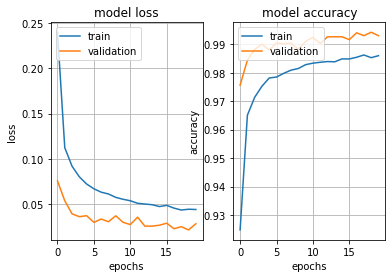

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [164]:
plt.subplot(1, 2, 1)
plt.title('model loss')
plt.plot(history01.history['loss'])
plt.plot(history01.history['val_loss'])
#plt.gca().set_ylim(0, 0.25)
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(history01.history['accuracy'])
plt.plot(history01.history['val_accuracy'])
#plt.gca().set_ylim(0.75, 1)
plt.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print(history01.history.keys())

In [161]:
%tensorboard --logdir log_dir

In [165]:
best_model = keras.models.load_model(model_path)
_, acc = best_model.evaluate(X_test, y_test)
print("Accuracy: %.2f" % round(acc*100, 2))

313/313 [==============================] - 1s 2ms/step - loss: 0.0261 - accuracy: 0.9908
Accuracy: 99.08


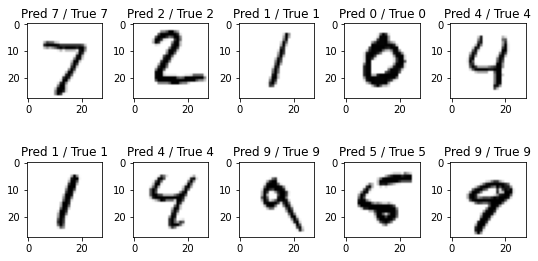

In [166]:
def image_plot(X, y, model, num=10):
    # plot data
    num_row = 2
    num_col = 5
    images = X[:num]
    y_true = y[:num]
    y_pred = tf.argmax(model.predict(images), axis=1)

    images = images.reshape((images.shape[0], 28, 28))
    
    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap='gray_r')
        ax.set_title('Pred {} / True {}'.format(y_pred[i], y_true[i]))
    plt.tight_layout()
    plt.show()

image_plot(X_test, y_test_raw, best_model)